# Project Overview: Self-Supervised Learning with MoCo v2 for Dental X-Ray Analysis
This notebook implements a self-supervised learning (SSL) pipeline using Momentum Contrast (MoCo v2) to pre-train a YOLOv11 backbone on dental X-ray images.

## What this notebook does
1. Preparing Data:

The raw dental datasets are separated into structured training and validation directories. To prepare the data for use with YOLO training, unique tooth classes are detected and assigned to the dental_multiclass.yaml configuration file.A dual view image augmentation pipeline (SSLTransform) has been developed to create pairs of images for contrastive learning by randomly flipping, color-adjusting, and converting images to grayscale.

2. MoCo Pre-training:

The MoCo algorithm uses a YOLOv11n backbone wrapped in a custom encoder to extract deep image features.
It combines a Query (q) and Momentum Key (k) encoder architecture, with the key encoder updated via Exponential Moving Average (EMA).
Using the dictionary queue of negative samples, the MoCo algorithm optimises a contrastive loss function by comparing positive pairs with the dictionary of negatives.
3. Self-Supervised Pre-training:

The model learns to create high-quality image feature representations of dental X-ray images in the absence of labels by maximising agreement between augmented views of identical images. For the YOLO backbone, the MoCo algorithm runs a pre-training loop for 50 epochs.

4. Diagnostics & Fine-Tuning:

Pre-trained YOLOv11n backbone weights are saved for future use.The MoCo algorithm provides a foundation for performing supervised fine-tuning on object detection and tooth classification tasks using the image feature representations learned through self-supervised pre-training techniques.

## Dataset:
1. Root (Source Paths):

* Images: /kaggle/input/dental-x-ray/Multi-Source Dental X-Ray Dataset Using Image-to-I/Teeth Xray Image Dataset/Teeth Xray Image Dataset/Teeth View Xray Image Dataset/Dental Xray (Ojected Detection)/images

* Labels: /kaggle/input/dental-x-ray/Multi-Source Dental X-Ray Dataset Using Image-to-I/Teeth Xray Image Dataset/Teeth Xray Image Dataset/Teeth View Xray Image Dataset/Dental Xray (Ojected Detection)/labels

2. Output (Work Directory):

After organization and split, files are structured under: /kaggle/working/datasets/dental Structure: * images/{train, val}

## Reading the Results
 
* Detection Performance: After fine-tuning, the model achieved a mAP50 (mean 
Average Precision at IoU 0.5) of approximately 0.187. 
*  Counting Error (MAE): The model was evaluated on how accurately it counts teeth per 
class: 
* Tooth_Class_0: MAE 2.65 
* Tooth_Class_3: MAE 1.09 (Best performing) 
* Tooth_Class_4: MAE 0.99 (Best performing). 

## --- INSTALL & SETUP ---


In [1]:
# --- INSTALL & SETUP ---
import os
try:
    from ultralytics import YOLO
except ImportError:
    os.system('pip install -U ultralytics --no-deps --quiet')
    from ultralytics import YOLO

import glob
import random
import shutil
import requests
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

# Set Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Environment ready. Using device: {DEVICE}")

# Set Random Seed for Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
set_seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.6 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Environment ready. Using device: cuda


## --- CONFIGURATION ---


In [ ]:
CONFIG = {
    "img_size": 224,      # Size for MoCo Pre-training
    "det_img_size": 640,  # Size for Fine-Tuning
    "batch_size": 32,     # Adjust if running out of memory
    "epochs_ssl": 50,     # 50 Epochs for MoCo
    "epochs_finetune": 50,
    "lr": 1e-3,
    
    # INPUT PATHS 
    "images_path": "/kaggle/input/dental-x-ray/Multi-Source Dental X-Ray Dataset Using Image-to-I/Teeth Xray Image Dataset/Teeth Xray Image Dataset/Teeth View Xray Image Dataset/Dental Xray (Ojected Detection)/images",
    "labels_path": "/kaggle/input/dental-x-ray/Multi-Source Dental X-Ray Dataset Using Image-to-I/Teeth Xray Image Dataset/Teeth Xray Image Dataset/Teeth View Xray Image Dataset/Dental Xray (Ojected Detection)/labels",
    
    # OUTPUT WORK DIR
    "work_dir": "/kaggle/working/datasets/dental"
}

# --- DATA ORGANIZATION ---
if os.path.exists(CONFIG["work_dir"]): shutil.rmtree(CONFIG["work_dir"])

# 1. Get Files
all_images = glob.glob(os.path.join(CONFIG["images_path"], "*.jpg")) + \
             glob.glob(os.path.join(CONFIG["images_path"], "*.png"))
train_files, val_files = train_test_split(all_images, test_size=0.2, random_state=42)

# 2. Copy Files
print("Organizing dataset...")
for split, files in zip(['train', 'val'], [train_files, val_files]):
    os.makedirs(f"{CONFIG['work_dir']}/images/{split}", exist_ok=True)
    os.makedirs(f"{CONFIG['work_dir']}/labels/{split}", exist_ok=True)
    
    for img_path in files:
        file_name = os.path.basename(img_path)
        shutil.copy(img_path, f"{CONFIG['work_dir']}/images/{split}/{file_name}")
        
        lbl_name = file_name.rsplit('.', 1)[0] + ".txt"
        src_lbl = os.path.join(CONFIG["labels_path"], lbl_name)
        if os.path.exists(src_lbl):
            shutil.copy(src_lbl, f"{CONFIG['work_dir']}/labels/{split}/{lbl_name}")

print(f"Data setup complete. Train: {len(train_files)}, Val: {len(val_files)}")

Organizing dataset...
Data setup complete. Train: 1319, Val: 330


## ---Label Processing---

In [3]:
print("Scanning labels to detect classes...")
label_files = glob.glob(f"{CONFIG['work_dir']}/labels/train/*.txt")
all_classes = []

for f in label_files:
    with open(f, 'r') as file:
        for line in file:
            parts = line.split()
            if len(parts) > 0:
                all_classes.append(int(parts[0]))

unique_classes = sorted(list(set(all_classes)))
NUM_CLASSES = len(unique_classes)
CLASS_NAMES = {i: f"Tooth_Class_{i}" for i in unique_classes}

print(f"--- DETECTED {NUM_CLASSES} CLASSES ---")
print(CLASS_NAMES)

# Create YAML for Training
yaml_content = f"""
path: {CONFIG['work_dir']}
train: images/train
val: images/val
names:
"""
for k, v in CLASS_NAMES.items():
    yaml_content += f"  {k}: {v}\n"

with open("dental_multiclass.yaml", "w") as f: f.write(yaml_content)
print("dental_multiclass.yaml created.")

Scanning labels to detect classes...
--- DETECTED 6 CLASSES ---
{0: 'Tooth_Class_0', 1: 'Tooth_Class_1', 2: 'Tooth_Class_2', 3: 'Tooth_Class_3', 4: 'Tooth_Class_4', 5: 'Tooth_Class_5'}
dental_multiclass.yaml created.


## ---SSL Dataset---

In [4]:
class SSLTransform:
    def __init__(self, size):
        s = 1.0
        self.transform = T.Compose([
            T.Resize((size, size)),
            T.RandomHorizontalFlip(),
            T.RandomApply([T.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)], p=0.8),
            T.RandomGrayscale(p=0.2),
            T.ToTensor(),
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
        ])

    def __call__(self, x):
        return self.transform(x), self.transform(x)

class DentalSSLDataset(Dataset):
    def __init__(self, image_paths, size=224):
        self.image_paths = image_paths
        self.transform = SSLTransform(size)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        x_i, x_j = self.transform(image)
        return x_i, x_j

# Create Loader
ssl_dataset = DentalSSLDataset(train_files, size=CONFIG["img_size"])
ssl_loader = DataLoader(
    ssl_dataset, 
    batch_size=CONFIG["batch_size"], 
    shuffle=True, 
    drop_last=True, 
    num_workers=2,
    pin_memory=True
)
print("SSL Data Loader Ready.")

SSL Data Loader Ready.


## ---MoCo Architecture---

In [5]:
# Force Download Weights
weight_file = "yolo11n.pt"
if not os.path.exists(weight_file):
    print(f"Downloading {weight_file}...")
    url = "https://github.com/ultralytics/assets/releases/download/v8.3.0/yolo11n.pt"
    with open(weight_file, "wb") as f: f.write(requests.get(url).content)

class MoCo_YOLOv11(nn.Module):
    def __init__(self, backbone_path, dim=128, K=1024, m=0.999, T=0.07):
        super().__init__()
        self.K = K
        self.m = m
        self.T = T
        
        print(f"Initializing MoCo from {backbone_path}...")
        
        # We need two encoders: Query (q) and Key (k)
        self.encoder_q = self._get_encoder(backbone_path, dim)
        self.encoder_k = self._get_encoder(backbone_path, dim)
        
        # Initialize k = q and freeze k
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)
            param_k.requires_grad = False  # Keys are not updated by gradient

        # Queue (Buffer of negatives)
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    def _get_encoder(self, path, dim):
        yolo = YOLO(path)
        backbone = yolo.model
        
        # Replace Head with Identity safely
        old_head = backbone.model[-1]
        backbone.model[-1] = nn.Identity()
        # Copy attributes to prevent YOLO errors
        backbone.model[-1].i = old_head.i
        backbone.model[-1].f = old_head.f
        
        # Projection Head (YOLOv11n P5 dim is 256)
        return nn.Sequential(
            backbone,
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 256), 
            nn.ReLU(),
            nn.Linear(256, dim)
        )

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        """ Update momentum encoder: k = m*k + (1-m)*q """
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        batch_size = keys.shape[0]
        ptr = int(self.queue_ptr)
        
        # Replace keys at pointer
        if ptr + batch_size > self.K:
            batch_size = self.K - ptr
            keys = keys[:batch_size]
            
        self.queue[:, ptr:ptr + batch_size] = keys.T
        ptr = (ptr + batch_size) % self.K
        self.queue_ptr[0] = ptr

    def forward(self, im_q, im_k):
        # 1. Encode Query
        q = self.encoder_q(im_q)
        q = nn.functional.normalize(q, dim=1)

        # 2. Encode Key (with momentum)
        with torch.no_grad():
            self._momentum_update_key_encoder()
            k = self.encoder_k(im_k)
            k = nn.functional.normalize(k, dim=1)

        # 3. Calculate Logits (Contrastive Loss Inputs)
        # Positive logits: q * k+
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        # Negative logits: q * queue
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])
        
        # Concatenate and Scale
        logits = torch.cat([l_pos, l_neg], dim=1)
        logits /= self.T
        
        # Labels: positives are always at index 0
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(q.device)
        
        # Update Queue
        self._dequeue_and_enqueue(k)
        
        return logits, labels


print("DONE!")

DONE!


## ---YOLO Encoder Wrapper and Architecture Refinement---

In [6]:
# Force Download Weights
weight_file = "yolo11n.pt"
if not os.path.exists(weight_file):
    print(f"Downloading {weight_file}...")
    url = "https://github.com/ultralytics/assets/releases/download/v8.3.0/yolo11n.pt"
    with open(weight_file, "wb") as f: f.write(requests.get(url).content)

# --- HELPER CLASS TO FIX LIST OUTPUT ---
class YOLOEncoderWrapper(nn.Module):
    def __init__(self, backbone, dim=128):
        super().__init__()
        self.backbone = backbone
        # Projector: P5 channel count is 256 for YOLOv11n
        self.projector = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(256, 256), 
            nn.ReLU(),
            nn.Linear(256, dim)
        )
        
    def forward(self, x):
        features = self.backbone(x)
        # YOLO returns a list [P3, P4, P5]. We take the last one (deepest features).
        if isinstance(features, (list, tuple)): 
            features = features[-1]
        return self.projector(features)

class MoCo_YOLOv11(nn.Module):
    def __init__(self, backbone_path, dim=128, K=1024, m=0.999, T=0.07):
        super().__init__()
        self.K = K
        self.m = m
        self.T = T
        
        print(f"Initializing MoCo from {backbone_path}...")
        
        self.encoder_q = self._get_encoder(backbone_path, dim)
        self.encoder_k = self._get_encoder(backbone_path, dim)
        
        # Initialize k = q and freeze k
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)
            param_k.requires_grad = False  # Keys are not updated by gradient

        # Queue
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    def _get_encoder(self, path, dim):
        yolo = YOLO(path)
        backbone = yolo.model
        
        # Replace Head with Identity safely
        old_head = backbone.model[-1]
        backbone.model[-1] = nn.Identity()
        backbone.model[-1].i = old_head.i
        backbone.model[-1].f = old_head.f
        
        # Return our custom wrapper instead of nn.Sequential
        return YOLOEncoderWrapper(backbone, dim)

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        batch_size = keys.shape[0]
        ptr = int(self.queue_ptr)
        
        if ptr + batch_size > self.K:
            batch_size = self.K - ptr
            keys = keys[:batch_size]
            
        self.queue[:, ptr:ptr + batch_size] = keys.T
        ptr = (ptr + batch_size) % self.K
        self.queue_ptr[0] = ptr

    def forward(self, im_q, im_k):
        # 1. Encode Query
        q = self.encoder_q(im_q)
        q = nn.functional.normalize(q, dim=1)

        # 2. Encode Key
        with torch.no_grad():
            self._momentum_update_key_encoder()
            k = self.encoder_k(im_k)
            k = nn.functional.normalize(k, dim=1)

        # 3. Logits
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])
        
        logits = torch.cat([l_pos, l_neg], dim=1)
        logits /= self.T
        
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(q.device)
        self._dequeue_and_enqueue(k)
        
        return logits, labels

## ---MoCo Pre-training Loop---

Initializing MoCo from yolo11n.pt...
Starting MoCo Pre-training for 50 epochs...


MoCo Epoch 50/50: 100%|██████████| 41/41 [00:09<00:00,  4.47it/s, loss=4.1761]


MoCo Training Complete. Backbone Saved.


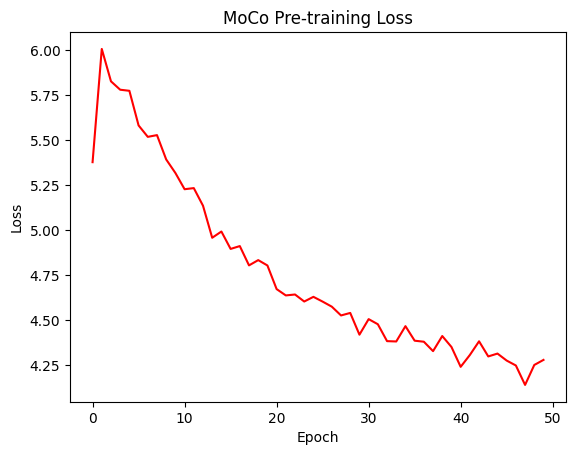

In [7]:
# Initialize
moco_model = MoCo_YOLOv11(weight_file, dim=128, K=1024).to(DEVICE)
optimizer = optim.Adam(moco_model.encoder_q.parameters(), lr=CONFIG["lr"])
criterion = nn.CrossEntropyLoss()

moco_losses = []
print(f"Starting MoCo Pre-training for {CONFIG['epochs_ssl']} epochs...")
moco_model.train()

for epoch in range(CONFIG['epochs_ssl']):
    total_loss = 0
    pbar = tqdm(ssl_loader, desc=f"MoCo Epoch {epoch+1}/{CONFIG['epochs_ssl']}", mininterval=1.0)
    
    for x_q, x_k in pbar:
        x_q, x_k = x_q.to(DEVICE), x_k.to(DEVICE)
        
        optimizer.zero_grad()
        logits, labels = moco_model(x_q, x_k)
        
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")
        
    avg_loss = total_loss / len(ssl_loader)
    moco_losses.append(avg_loss)

# IMPORTANT: Save the backbone from the wrapper (encoder_q.backbone)
torch.save(moco_model.encoder_q.backbone.state_dict(), "moco_backbone.pt")
print("MoCo Training Complete. Backbone Saved.")

plt.plot(moco_losses, color='red')
plt.title("MoCo Pre-training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## ---Fine-Tuning---

In [ ]:
print("Initializing Fine-Tuning Phase...")
moco_detector = YOLO("yolo11n.pt") # Fresh Detector

try:
    print("Loading MoCo Pre-trained Weights...")
    # Load state dict
    state_dict = torch.load("moco_backbone.pt")
    
    # Load into the detector backbone (strict=False ignores the head)
    moco_detector.model.model.load_state_dict(state_dict, strict=False)
    print("Weights transferred successfully!")
except Exception as e:
    print(f"Warning: Weight transfer failed ({e}). Using default COCO weights.")

# Train Detector
results = moco_detector.train(
    data="dental_multiclass.yaml",
    epochs=CONFIG["epochs_finetune"],
    imgsz=CONFIG["det_img_size"],
    batch=16,
    project="Dental_Project",
    name="MoCo_Run"
)

Initializing Fine-Tuning Phase...
Loading MoCo Pre-trained Weights...
Weights transferred successfully!
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dental_multiclass.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=MoCo_Run, nbs=64, nms=False,

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        330       3739      0.256      0.284      0.187     0.0521
         Tooth_Class_0        288        881      0.271      0.269      0.176     0.0482
         Tooth_Class_1        289        796      0.224      0.142      0.113     0.0303
         Tooth_Class_2        193        439      0.231     0.0934     0.0709     0.0206
         Tooth_Class_3        210        375      0.266       0.36      0.212     0.0625
         Tooth_Class_4        269        542      0.294       0.57       0.39      0.103
         Tooth_Class_5        278        706      0.251      0.269      0.159     0.0477
Speed: 0.3ms preprocess, 2.4ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to /kaggle/working/Dental_Project/MoCo_Run


## ---Performance Evaluation and Visualization---

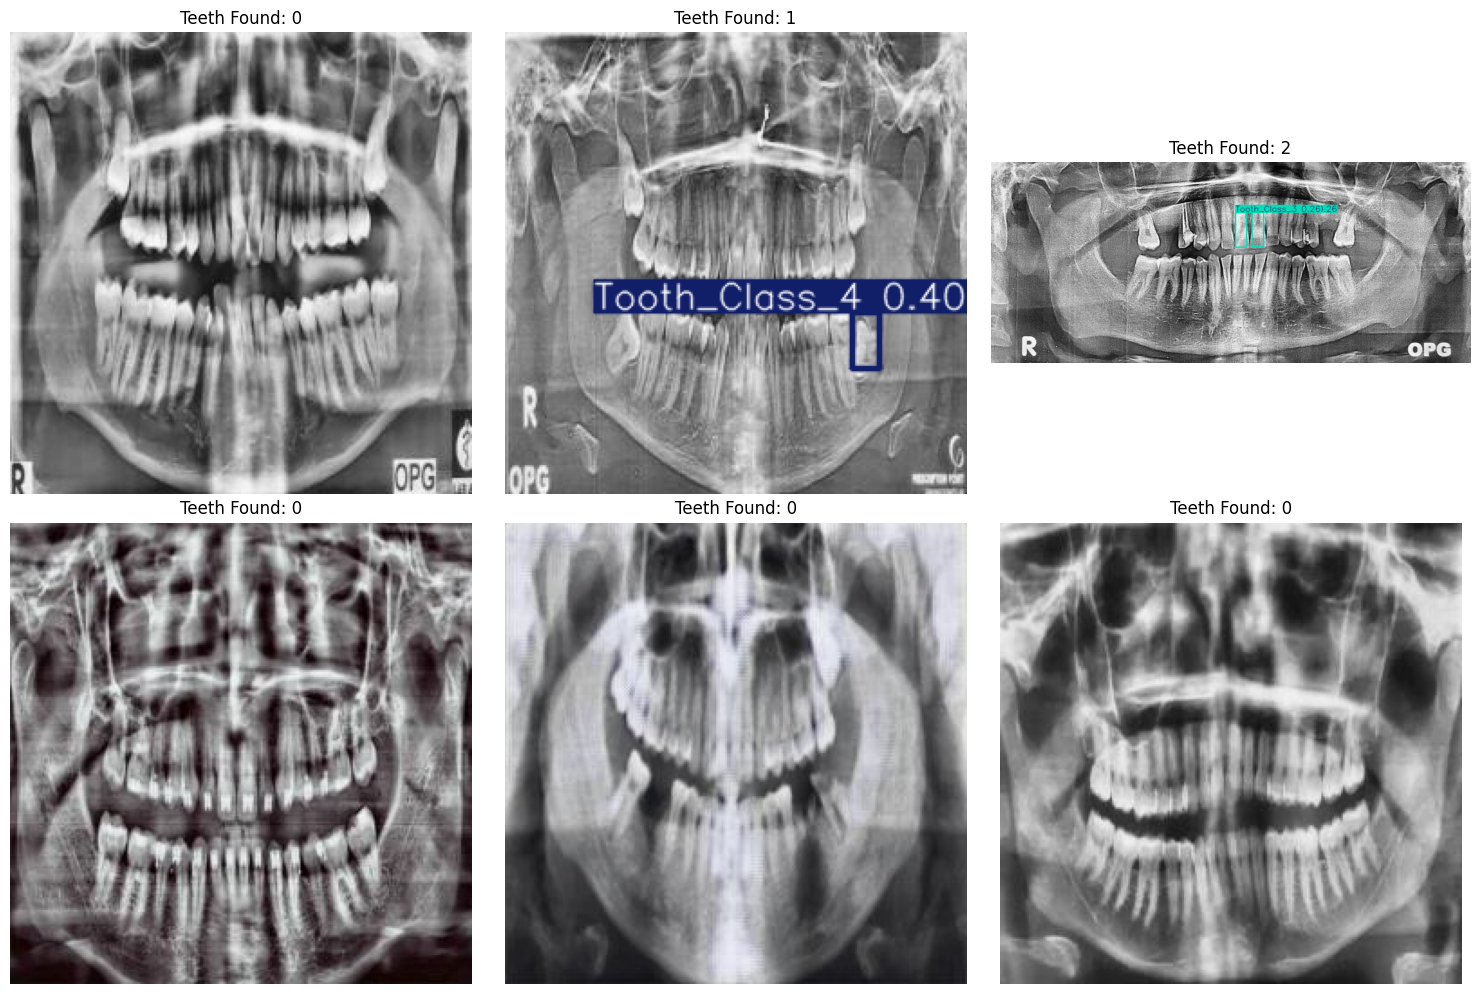

In [9]:
import cv2

def visualize_moco_results(model_path, img_dir, num_samples=6):
    model = YOLO(model_path)
    images = glob.glob(f"{img_dir}/*.jpg") + glob.glob(f"{img_dir}/*.png")
    
    if not images: return
    
    samples = random.sample(images, min(num_samples, len(images)))
    
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(samples):
        # Predict
        results = model.predict(img_path, conf=0.25, verbose=False)[0]
        
        # Plot
        res_plotted = results.plot(line_width=2)
        res_rgb = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)
        
        plt.subplot(2, 3, i+1)
        plt.imshow(res_rgb)
        plt.title(f"Teeth Found: {len(results.boxes)}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Run Visualization
best_weight = f"/kaggle/working/Dental_Project/MoCo_Run/weights/best.pt"
if os.path.exists(best_weight):
    visualize_moco_results(best_weight, f"{CONFIG['work_dir']}/images/val")
else:
    print("Training did not produce a best.pt file. Check Cell 7 logs.")

## ---Detection & Counting Analysis---

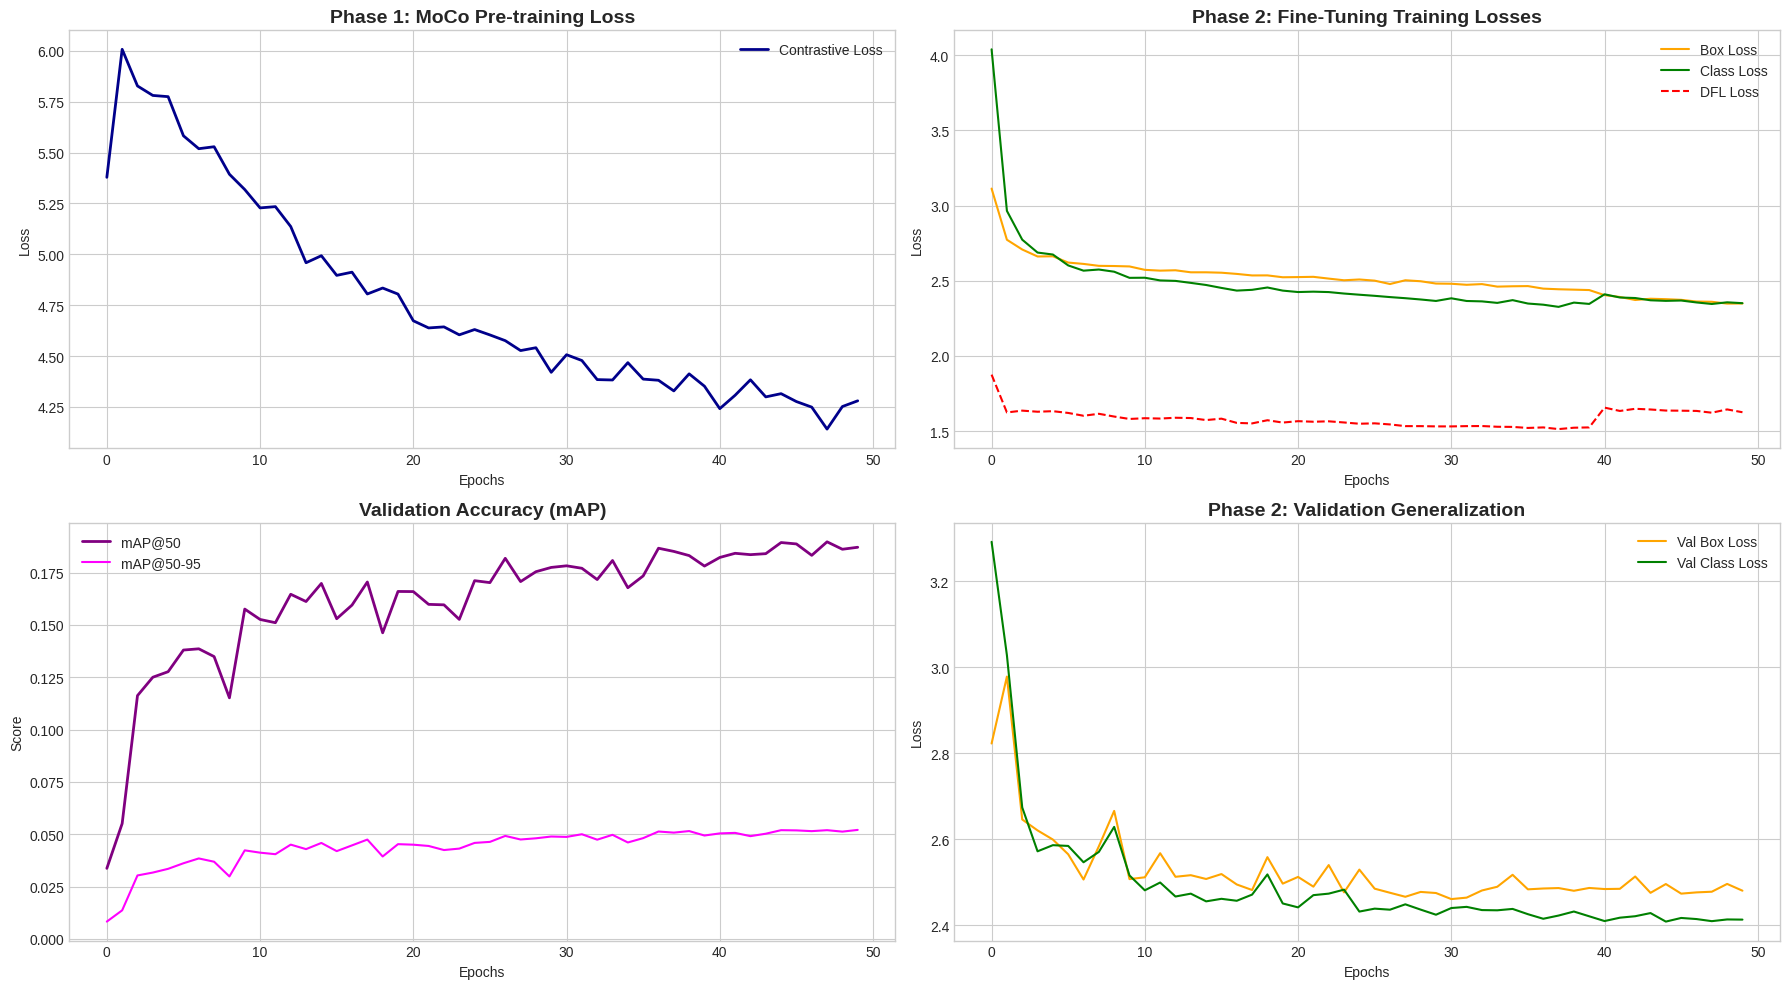


Evaluating Counting Accuracy on /kaggle/working/datasets/dental/images/val...


Running Inference: 100%|██████████| 330/330 [00:04<00:00, 70.02it/s]


CLASS NAME           | MAE (Error)  | RMSE         | Total True
Tooth_Class_0        | 2.6545       | 3.3457       | 881       
Tooth_Class_1        | 2.3182       | 2.8768       | 796       
Tooth_Class_2        | 1.3182       | 2.1070       | 439       
Tooth_Class_3        | 1.0939       | 1.5443       | 375       
Tooth_Class_4        | 0.9909       | 1.3981       | 542       
Tooth_Class_5        | 2.1030       | 2.6423       | 706       
-----------------------------------------------------------------
AVERAGE              | 1.7465


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import glob
import os
from collections import Counter
from ultralytics import YOLO

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')

def plot_training_curves(moco_losses, results_csv_path):
    plt.figure(figsize=(18, 10))
    
    # --- 1. MoCo Pre-training Loss ---
    plt.subplot(2, 2, 1)
    if moco_losses and len(moco_losses) > 0:
        plt.plot(moco_losses, label='Contrastive Loss', color='darkblue', linewidth=2)
        plt.title("Phase 1: MoCo Pre-training Loss", fontsize=14, fontweight='bold')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
    else:
        plt.text(0.5, 0.5, "MoCo Loss Data Not Available", ha='center', fontsize=12)
        plt.title("Phase 1: MoCo Pre-training Loss")

    # Check if Fine-Tuning results exist
    if os.path.exists(results_csv_path):
        df = pd.read_csv(results_csv_path)
        df.columns = [c.strip() for c in df.columns] # Fix whitespace in col names

        # --- 2. Detection Losses (Box, Class) ---
        plt.subplot(2, 2, 2)
        plt.plot(df['train/box_loss'], label='Box Loss', color='orange')
        plt.plot(df['train/cls_loss'], label='Class Loss', color='green')
        plt.plot(df['train/dfl_loss'], label='DFL Loss', color='red', linestyle='--')
        plt.title("Phase 2: Fine-Tuning Training Losses", fontsize=14, fontweight='bold')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()

        # --- 3. Validation Metrics (mAP) ---
        plt.subplot(2, 2, 3)
        plt.plot(df['metrics/mAP50(B)'], label='mAP@50', color='purple', linewidth=2)
        plt.plot(df['metrics/mAP50-95(B)'], label='mAP@50-95', color='magenta')
        plt.title("Validation Accuracy (mAP)", fontsize=14, fontweight='bold')
        plt.xlabel("Epochs")
        plt.ylabel("Score")
        plt.legend()
        
        # --- 4. Validation Losses ---
        plt.subplot(2, 2, 4)
        plt.plot(df['val/box_loss'], label='Val Box Loss', color='orange')
        plt.plot(df['val/cls_loss'], label='Val Class Loss', color='green')
        plt.title("Phase 2: Validation Generalization", fontsize=14, fontweight='bold')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()

    else:
        plt.subplot(2, 2, 2)
        plt.text(0.5, 0.5, "Fine-Tuning CSV Not Found", ha='center')

    plt.tight_layout()
    plt.show()

def evaluate_counting_performance(model_path, val_img_dir, val_lbl_dir, num_classes):
    print(f"\nEvaluating Counting Accuracy on {val_img_dir}...")
    model = YOLO(model_path)
    
    # Dictionary to store true vs pred counts for each class
    # Format: {class_id: {'true': [], 'pred': []}}
    stats = {i: {'true': [], 'pred': []} for i in range(num_classes)}
    
    val_images = glob.glob(f"{val_img_dir}/*.jpg") + glob.glob(f"{val_img_dir}/*.png")
    
    for img_path in tqdm(val_images, desc="Running Inference"):
        # 1. Get Ground Truth
        lbl_path = os.path.join(val_lbl_dir, os.path.basename(img_path).rsplit('.', 1)[0] + ".txt")
        true_counts = Counter()
        if os.path.exists(lbl_path):
            with open(lbl_path, 'r') as f:
                for line in f:
                    cls_id = int(line.split()[0])
                    true_counts[cls_id] += 1
        
        # 2. Get Predictions
        # conf=0.25 is standard, lower it if model is missing teeth
        results = model.predict(img_path, conf=0.25, verbose=False)[0]
        pred_counts = Counter(results.boxes.cls.cpu().numpy().astype(int))
        
        # 3. Store Results
        for c in range(num_classes):
            stats[c]['true'].append(true_counts[c])
            stats[c]['pred'].append(pred_counts[c])

    # --- Print Table ---
    print("\n" + "="*65)
    print(f"{'CLASS NAME':<20} | {'MAE (Error)':<12} | {'RMSE':<12} | {'Total True':<10}")
    print("="*65)
    
    total_mae = 0
    
    for c in range(num_classes):
        t = np.array(stats[c]['true'])
        p = np.array(stats[c]['pred'])
        
        mae = mean_absolute_error(t, p)
        rmse = np.sqrt(mean_squared_error(t, p))
        total_true = np.sum(t)
        
        cls_name = CLASS_NAMES.get(c, f"Class {c}")
        print(f"{cls_name:<20} | {mae:.4f}       | {rmse:.4f}       | {total_true:<10}")
        total_mae += mae
        
    print("-" * 65)
    print(f"{'AVERAGE':<20} | {total_mae/num_classes:.4f}")
    print("="*65)

# --- EXECUTE ---
# 1. Plot Curves
# Note: 'moco_losses' comes from the previous cell. If variable is lost, pass empty list []
results_path = "/kaggle/working/Dental_Project/MoCo_Run/results.csv"
plot_training_curves(moco_losses if 'moco_losses' in globals() else [], results_path)

# 2. Run Counting Evaluation
best_weight = "/kaggle/working/Dental_Project/MoCo_Run/weights/best.pt"
if os.path.exists(best_weight):
    evaluate_counting_performance(
        best_weight,
        f"{CONFIG['work_dir']}/images/val",
        f"{CONFIG['work_dir']}/labels/val",
        CONFIG.get("num_classes", NUM_CLASSES) # Fallback to global variable if CONFIG missing
    )
else:
    print("Error: Fine-tuned weights not found. Did training finish?")